In [35]:
# import getpass
# import os


# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")
# _set_env("TAVILY_API_KEY")

In [36]:
import os
import shutil
import sqlite3
import pandas as pd
import requests
import re
import numpy as np
import openai
import pytz
from datetime import datetime, date
from typing import Optional, Union
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition


In [37]:
db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
backup_file = "travel2.backup.sqlite"
overwrite = False  # set to True if you wish to force a new download

if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Check that the download was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Create a backup so that you can "reset" the DB later if needed.
    shutil.copy(local_file, backup_file)

def update_dates(file: str) -> str:
    """
    Reset the database from the backup and shift the flight and booking dates
    to be in the near future relative to the current time.
    """
    # Reset the DB to its backed-up state
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    # Read all tables into a dictionary of DataFrames
    tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * FROM {t}", conn)

    # Determine a time offset based on the flights’ actual departure dates.
    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    # Update booking dates
    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    # Update flight date/time columns
    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    # Write updated DataFrames back to the database.
    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    conn.commit()
    conn.close()
    return file

# Update the dates and assign the (local) database file path to 'db'
db = update_dates(local_file)

In [38]:
response = requests.get("https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md")
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]

class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(
            model="text-embedding-3-small",
            input=[doc["page_content"] for doc in docs]
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model="text-embedding-3-small",
            input=[query]
        )
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]

# Initialize the retriever (if you wish to call the lookup_policy tool)
retriever = VectorStoreRetriever.from_docs(docs, openai.Client())


In [39]:
@tool
def lookup_policy(query: str) -> str:
    """
    Consult company policies (FAQ document) to verify whether certain changes
    (flight/hotel modifications) are permitted.
    """
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])


In [40]:
@tool
def fetch_user_flight_information(config: RunnableConfig) -> list[dict]:
    """
    Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id")
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT 
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport,
        f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM 
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE 
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cursor.close()
    conn.close()
    return results


## Flights

In [41]:

@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[Union[date, datetime]] = None,
    end_time: Optional[Union[date, datetime]] = None,
    limit: int = 20,
) -> list[dict]:
    """
    Search for flights based on departure airport, arrival airport, and departure time range.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []
    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)
    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)
    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)
    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)

    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cursor.close()
    conn.close()
    return results

@tool
def update_ticket_to_new_flight(
    ticket_no: str, new_flight_id: int, *, config: RunnableConfig
) -> str:
    """
    Update the user's ticket to a new valid flight.
    """
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id")
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    # Retrieve details of the new flight
    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [desc[0] for desc in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))

    # Enforce a business rule: flight must be at least 3 hours away.
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        cursor.close()
        conn.close()
        return f"Not permitted to reschedule to a flight that is less than 3 hours away. Selected flight is at {departure_time}."

    # Ensure the ticket exists and is owned by the signed-in passenger.
    cursor.execute("SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Passenger {passenger_id} is not the owner of ticket {ticket_no}."

    # Update the ticket to the new flight.
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()
    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."

@tool
def cancel_ticket(ticket_no: str, *, config: RunnableConfig) -> str:
    """
    Cancel the user's ticket and remove it from the database.
    """
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id")
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    # Check that the ticket exists.
    cursor.execute("SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Verify ticket ownership.
    cursor.execute(
        "SELECT ticket_no FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Passenger {passenger_id} is not the owner of ticket {ticket_no}."

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()
    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."


## Hotels

In [42]:
@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[date, datetime]] = None,
    checkout_date: Optional[Union[date, datetime]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, and (optionally)
    check-in/check-out dates.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []
    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # You can add date or price tier filtering as needed.
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cursor.close()
    conn.close()
    return results

@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()
    if cursor.rowcount > 0:
        cursor.close()
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        cursor.close()
        conn.close()
        return f"No hotel found with ID {hotel_id}."

@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[date, datetime]] = None,
    checkout_date: Optional[Union[date, datetime]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?", (checkout_date, hotel_id)
        )
    conn.commit()
    if cursor.rowcount > 0:
        cursor.close()
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        cursor.close()
        conn.close()
        return f"No hotel found with ID {hotel_id}."

@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel booking by its ID.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()
    if cursor.rowcount > 0:
        cursor.close()
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        cursor.close()
        conn.close()
        return f"No hotel found with ID {hotel_id}."


In [43]:
def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )
#ToolNode -- to execute tools in langgraph we can use ToolNode, which will will have some extra features like to handle incase of error 

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [44]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str

In [45]:
class Assistant:
    def __init__(self,runnable:Runnable):
        self.runnable = runnable
    def __call__(self,state:State,config:RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [46]:
llm = ChatOpenAI()

In [47]:
assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

In [48]:
part_3_safe_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    search_hotels,
]

part_3_sensitive_tools = [
    update_ticket_to_new_flight,
    cancel_ticket,
    book_hotel,
    update_hotel,
    cancel_hotel,
]

In [49]:
sensitive_tool_names = {t.name for t in part_3_sensitive_tools}

In [50]:
part_3_assistant_runnable = assistant_prompt | llm.bind_tools(
    part_3_safe_tools + part_3_sensitive_tools
)

In [51]:
builder = StateGraph(State)

In [52]:
def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


In [53]:
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(part_3_assistant_runnable))
builder.add_node("safe_tools", create_tool_node_with_fallback(part_3_safe_tools))
builder.add_node(
    "sensitive_tools", create_tool_node_with_fallback(part_3_sensitive_tools)
)

In [54]:
builder.add_edge("fetch_user_info", "assistant")

def route_tools(state: State):
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"



In [55]:
builder.add_conditional_edges(
    "assistant", route_tools, ["safe_tools", "sensitive_tools", END]
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

In [56]:
memory = MemorySaver()
part_3_graph = builder.compile(
    checkpointer=memory,
    interrupt_before=["sensitive_tools"],
)

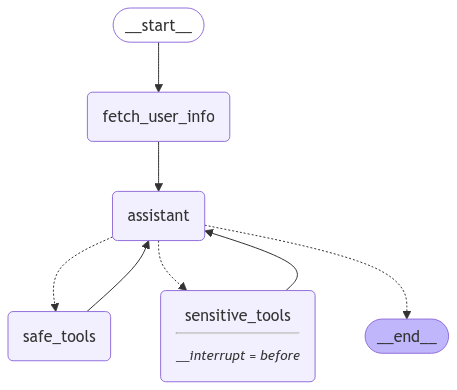

In [57]:
from IPython.display import Image, display

try:
    display(Image(part_3_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [58]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability."
]


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_3_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_3_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_3_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_cErZa4ekfXbt0K1xp4STLNck)
 Call ID: call_cErZa4ekfXbt0K1xp4STLNck
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2025-02-13 04:57:36.413910-04:00", "scheduled_arrival": "2025-02-13 06:27:36.413910-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]
================================== Ai Message ==================================

Your flight details are as follows:
- Flight Number: LX0112
- Departure Airport: CDG
- Arrival Airport: BSL
- Scheduled Departure: 2025-02-13 04:57:36 (in your 